# Stock predict
평가 산식: NMAE * 100


평가 (Public, Private score)
- public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
- private score: 11월 29일 ~ 12월 3일 주식 종료 예측값

In [5]:
!pip install finance-datareader

In [2]:
# !pip install OpenDartReader

In [3]:
# for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Colab_Notebooks/dacon/stockpredict

/content/drive/MyDrive/Colab_Notebooks/dacon/stockpredict


---------------

In [6]:
import pandas as pd
import numpy as np
import os
import joblib
import FinanceDataReader as fdr
# import OpenDartReader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# for LSTM model

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.models import load_model

# **Utility functions

In [8]:
def nmae(y_true, y_pred):
  """
  Normalized Mean Absoulte Error * 100

  Returns:
    eval_name, eval_result, is_higher_better
  """
  mae = mean_absolute_error(y_true, y_pred)
  abs_mean = np.mean(np.abs(y_true))
  return "NMAE", (mae / abs_mean) * 100, False

# ADF test
def adf_test(data):
  result = adfuller(data)
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'critical_values: {result[4]}')

def plot_two_y_axis(first_data, second_data, f_name="first", s_name="second"):
  # create figure and axis objects with subplots()
  fig,ax = plt.subplots()
  # make a plot
  ax.plot(first_data, color="red")
  # set x-axis label
  ax.set_xlabel("date")
  fig.autofmt_xdate(rotation=45)
  # set y-axis label
  ax.set_ylabel(f_name,color="red")

  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  # make a plot with different y-axis using second axis object
  ax2.plot(second_data, color="blue")
  ax2.set_ylabel(s_name,color="blue")
  plt.show()

In [9]:
path = './'
list_name = 'stock_list.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [10]:
start_date = '20210104'
end_date = '20211119'
sample_code = '005930'
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...
2021-11-15,71700,71900,70900,71400,12420710,0.011331
2021-11-16,71500,72000,71300,71300,10919239,-0.001401
2021-11-17,71300,71600,70600,70700,11027606,-0.008415


- Change : ROC를 의미? (Price Rate of Change)
  - momentum이라고도 불리는 듯 : ( (금일 종가 - N일전 종가) / N일전 종가 ) * 100
  - 주가가 변동성이 있을때만 의미있는 지표

In [ ]:
fdr.chart.plot(stock)

In [ ]:
# volume의 어제자와 차이(1차분)
fdr.chart.plot(stock)

In [ ]:
# volume의 지난주와이 차이(5칸 간격의 1차분)
fdr.chart.plot(stock)

In [11]:
start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'WEEKDAY of "end_date" : {pd.to_datetime(end_date).weekday()}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
WEEKDAY of "end_date" : 4
NUM of WEEKS to "end_date" : 46
HOW MANY "Business_days" : (230, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [ ]:
# 이미 영업일만 가져오는듯

# bday_idx = Business_days["Date"]
# bday_stock = stock.reindex(stock.index.intersection(bday_idx))
# fdr.chart.plot(bday_stock)

# OpenDART 기업 재무재표


In [ ]:
# https://opendart.fss.or.kr/
api_key = '8e8ab3b65172cf119b55c60984b4f7451b1e3b6b'
dart = OpenDartReader(api_key)

[OpenDART 개발가이드](https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019017)

|키|명칭|설명|
|---|---|---|
|corp_code|고유번호|공시대상회사의 고유번호(8자리)|
|bsns_year|사업연도|사업연도(4자리) ※ 2015년 이후 부터 정보제공|
|reprt_code|보고서코드|1분기보고서 : 11013|
|||반기보고서 : 11012|
|||3분기보고서 : 11014|
|||사업보고서 : 11011|

In [ ]:
dart.finstate_all(corp=stock_list.loc[0, '종목코드'], bsns_year=2021, reprt_code=11012)

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
0,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CurrentAssets,유동자산,-,제 53 기 반기말,191118524000000,제 52 기말,198215579000000,1,NaN,NaN,NaN,NaN
1,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CashAndCashEquivalents,현금및현금성자산,-,제 53 기 반기말,30683788000000,제 52 기말,29382578000000,2,NaN,NaN,NaN,NaN
2,20210817001416,11012,2021,00126380,BS,재무상태표,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,-,제 53 기 반기말,77777032000000,제 52 기말,92441703000000,3,NaN,NaN,NaN,NaN
3,20210817001416,11012,2021,00126380,BS,재무상태표,-표준계정코드 미사용-,단기상각후원가금융자산,-,제 53 기 반기말,2350399000000,제 52 기말,2757111000000,4,NaN,NaN,NaN,NaN
4,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CurrentFinancialAssetsAtFairValueThr...,단기당기손익-공정가치금융자산,-,제 53 기 반기말,49720000000,제 52 기말,71451000000,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|기타자본항목,제 53 기 반기,-6226066000000,NaN,NaN,13,NaN,제 52 기 반기,-3721095000000,NaN
180,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|매각예정분류기타자본항목,제 53 기 반기,0,NaN,NaN,13,NaN,제 52 기 반기,0,NaN
181,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|이익잉여금 [member],제 53 기 반기,275085185000000,NaN,NaN,13,NaN,제 52 기 반기,260165053000000,NaN
182,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|자본금 [member],제 53 기 반기,897514000000,NaN,NaN,13,NaN,제 52 기 반기,897514000000,NaN


# 검색어 트랜드 살피기

- google trend
- 크롤링 자동화는 데이터를 살펴 본 다음에..

In [ ]:
df_trend = pd.read_csv("./google_trend_samsung.csv", header=1, index_col=0)
df_trend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 2020-11-29 to 2021-11-14
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   삼성전자: (대한민국)  51 non-null     int64
dtypes: int64(1)
memory usage: 816.0+ bytes


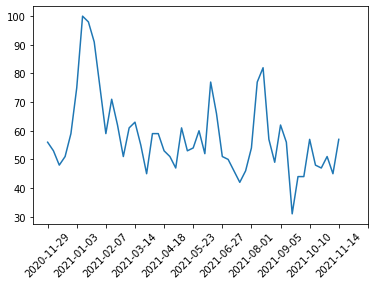

In [ ]:
plt.plot(df_trend)
plt.xticks(np.arange(0,60,5), rotation=45)
plt.show()

##0) Baseline code 따라하기
요일별 종가("Closed")를 linear regression로 예측
- 이번주 데이터로 다음주 예측

In [ ]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
02,55500.0,55800.0,56800.0,58600.0,59500.0
03,60000.0,60000.0,59000.0,60700.0,61300.0
04,62400.0,61400.0,62300.0,60800.0,60800.0
05,60800.0,58800.0,59100.0,57200.0,56400.0
06,57200.0,58900.0,59500.0,61100.0,60400.0


In [ ]:
sample.tail()

weekday,0,1,2,3,4
weeknum,,,,,
48,67500.0,67700.0,66600.0,68000.0,68200.0
49,66700.0,67800.0,69500.0,69700.0,71500.0
50,72900.0,71700.0,73900.0,72900.0,73400.0
51,73800.0,73800.0,73800.0,73300.0,73000.0
52,73000.0,72300.0,73900.0,77800.0,77800.0


In [ ]:
x = sample.iloc[0:-2].to_numpy()
x.shape

(49, 5)

In [ ]:
y = sample.iloc[1:-1].to_numpy()
y_0 = y[:,0]
y_1 = y[:,1]
y_2 = y[:,2]
y_3 = y[:,3]
y_4 = y[:,4]

y_values = [y_0, y_1, y_2, y_3, y_4]

In [ ]:
x_public = sample.iloc[-2].to_numpy()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

predictions = []
for y_value in y_values :
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0))
    predictions.append(prediction[0])

In [ ]:
print(f"y_pred : {predictions}\nvs\ny_public : {list(sample.iloc[-1].values)}")

y_pred : [73912.14870585549, 73508.90894414231, 73858.77902491373, 73367.23881923566, 73322.49774082401]
vs
y_public : [73000.0, 72300.0, 73900.0, 77800.0, 77800.0]


In [ ]:
nmae(list(sample.iloc[-1].values), predictions)

# 1) LightGBM
- feature를 만들어서 lgbm regression으로 시도해본다.
- hyperparams는 grid search나 bayesian optimization을 시도해본다.
- 성능이 안좋더라도, feature importance를 통해 feature의 효용성을 확인해본다.

In [ ]:
from lightgbm import LGBMRegressor

### features & preprocess
- 시가 ~ 종가 : Change
- Volume : 추세를 나타내는게 효과적일 듯?
- High ~ Low : 
- 상승 or 하락? : Change 수치로 대체될듯

In [ ]:
data = stock.copy()

In [ ]:
X = data[["Change","Close","Volume"]]

In [ ]:
# 미래 1주일 뒤(=각 날짜마다 5일 뒤)를 예측? -> 단순 다음주는 x.. 너무 naive한 접근법인듯. 그러나 어찌되었든 5일 후까지를 예측하는 문제이니, 5칸 영역 밖에서 해결해야한다.
# 어쨌든 중요한 점은 X feature에 최근 흐름을 담아야함
y = data["Close"].shift(-5).dropna()
y_train = y.iloc[:-20]
y_test = y.iloc[-20:]

In [ ]:
X_train = X.reindex(X.index.intersection(y_train.index))
X_test = X.reindex(X.index.intersection(y_test.index))

### model

In [ ]:
lgbm_model = LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
lgbm_model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=nmae,
        early_stopping_rounds=5)

[1]	valid_0's l2: 2.74411e+08	valid_0's NMAE: 0.226885
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 2.65491e+08	valid_0's NMAE: 0.223077
[3]	valid_0's l2: 2.57597e+08	valid_0's NMAE: 0.219651
[4]	valid_0's l2: 2.50545e+08	valid_0's NMAE: 0.216536
[5]	valid_0's l2: 2.44132e+08	valid_0's NMAE: 0.213663
[6]	valid_0's l2: 2.37193e+08	valid_0's NMAE: 0.21052
[7]	valid_0's l2: 2.31073e+08	valid_0's NMAE: 0.207708
[8]	valid_0's l2: 2.25622e+08	valid_0's NMAE: 0.205163
[9]	valid_0's l2: 2.19866e+08	valid_0's NMAE: 0.202449
[10]	valid_0's l2: 2.15208e+08	valid_0's NMAE: 0.200216
[11]	valid_0's l2: 2.10833e+08	valid_0's NMAE: 0.198095
[12]	valid_0's l2: 2.06815e+08	valid_0's NMAE: 0.196159
[13]	valid_0's l2: 2.0292e+08	valid_0's NMAE: 0.194231
[14]	valid_0's l2: 1.98536e+08	valid_0's NMAE: 0.192051
[15]	valid_0's l2: 1.94417e+08	valid_0's NMAE: 0.189979
[16]	valid_0's l2: 1.91128e+08	valid_0's NMAE: 0.188331
[17]	valid_0's l2: 1.87703e+08	valid_0's NMAE: 0.18657

LGBMRegressor(learning_rate=0.05, n_estimators=20)

In [ ]:
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration_)
# eval
print('NMAE * 100 :', (nmae(y_test, y_pred))[1])

# feature importances
print(
    'Feature importances:', 
    [pair for pair in zip(X.columns, list(lgbm_model.feature_importances_))]
)

NMAE * 100 : 18.237378574862305
Feature importances: [('Change', 20), ('Close', 96), ('Volume', 37)]


-> validation set에서는 성능이 잘나오는데, 테스트셋의 성능이 최악이다.

-> feature를 전혀 가공하지 않았기 때문도 있지만, 문제 정의 자체가 힘든 듯 : 1일 후~ 5일 후까지 예측 필요. 베이스라인 코드와 같이, 1일후 모델 ~ 5일후 모델 총 5개를 만들어도 되겠으나, 개별적인 데이터 모델링이 필요해보인다.

# 2) Sequence model
- 모델은 간단한 LSTM을 쓰고, 추후에 다른 시퀀스나 어탠션을 넣어본다.
- DNN 레이어 자체보다는, 데이터 가공에 신경써보자

In [12]:
## X sequence size, Y sequence size 정의
step_size = 30 # 약 6주치
unit_size = 5 # 총 5일 예측할 것임

"""
L : total length
W : x step size(input sequence Window size)
P : y unit size(Predicting sequence size)일때,

=> W만큼 X데이터 시퀀스를 넣어 P만큼의 시퀀스 길이를 예측한다.

X data shape : (L-W+1, W, num_features)
Y data shape : (L-W-P+1, P)
"""

'\nL : total length\nW : x step size(input sequence Window size)\nP : y unit size(Predicting sequence size)일때,\n\n=> W만큼 X데이터 시퀀스를 넣어 P만큼의 시퀀스 길이를 예측한다.\n\nX data shape : (L-W+1, W, num_features)\nY data shape : (L-W-P+1, P)\n'

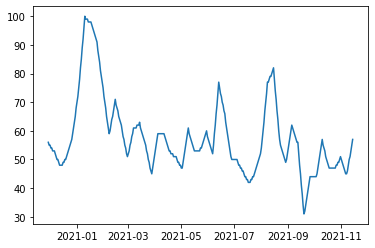

In [ ]:
# trend를 동일 인덱스로 맞추기 위한 가공
df_trend.index = df_trend.index.astype("datetime64[ns]")
df_trend = df_trend.resample("D").asfreq()
df_trend = df_trend.interpolate().astype(int)
plt.plot(df_trend)
plt.show()

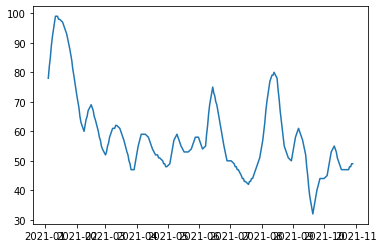

In [ ]:
df_trend = df_trend.reindex(Business_days["Date"].astype("datetime64[ns]"))
plt.plot(df_trend)
plt.show()

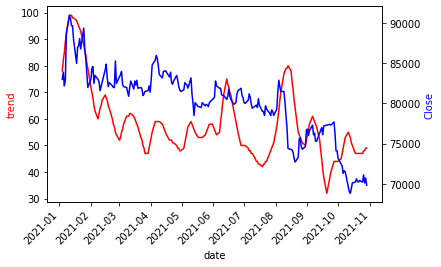

In [ ]:
plot_two_y_axis(df_trend, stock["Close"], "trend", "Close")

In [ ]:
# pd series로 만들기
df_trend = df_trend[df_trend.columns[0]]

In [ ]:
# index 맞추기
common_idx = stock["Close"].index.intersection(df_trend.index)
df_trend = df_trend.reindex(common_idx)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_

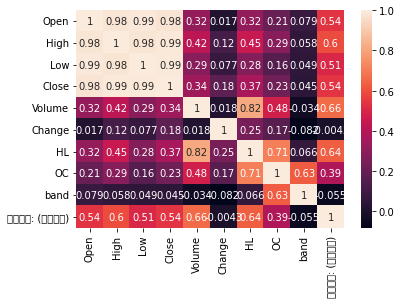

In [ ]:
# Correlation 확인
# 여러가지 컬럼을 가공 및 믹스한 feature를 만들어내본다
df_test = stock.copy()
df_test["HL"] = df_test["High"] - df_test["Low"] # High - Low 차이
df_test["OC"] = (df_test["Open"] - df_test["Close"]).abs() # Open, Close 차이
df_test["band"] = df_test["OC"] / df_test["HL"] # High~Low 대비 Open~Close
# df_test["Voldiff"] = (df_test["Volume"] - df_test["Volume"].shift(1)).interpolate().astype(int) # Volume 1차분

df_test = pd.concat([df_test, df_trend], axis=1)
sns.heatmap(df_test.corr(method="pearson"), annot=True)

==> correlation은 큰 의미는 없는듯하다.. Open, High, Low 전부 Close와 유사한 형태로 따라가기때문에 correlation이 높게나오는건 당연한게 아닐까?

### correlation 등 두 시계열의 synchrony를 확인하는 방법 :

[four-ways-to-quantify-synchrony-between-time-series-data](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)

1. 피어슨 상관계수 : simple is best
2. TLCC(Time Lagged Cross Corr), WTLCC(Windowed~)
3. DTW(Dynamic Time Warping)
4. Instantaneous phase synchrony

이 중 과거 시간대의 데이터를 활용해 미래 시간예측을 하기 위해, 2번의 방법을 시도해본다. TLCC 방법 중엔 대표적으로 아래에 granger causality test가 있다.

- 참고: 인과관계 분석에서 인과관계를 보여도, 실제 현실세계에서 인과관계를 갖는다는 증거가 되지 않음에 유의하자

Test Statistics: -13.660246469977183
p-value: 1.5262756766053516e-25
critical_values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
Test Statistics: -6.8477958618359684
p-value: 1.724910001233379e-09
critical_values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}
Test Statistics: -3.135581701047719
p-value: 0.02402960974968417
critical_values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}


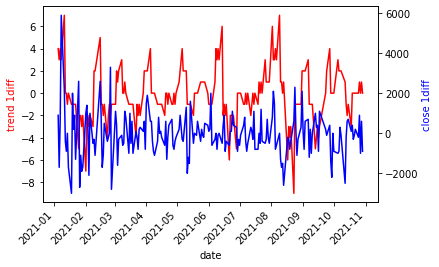

In [ ]:
close_diff = (stock["Close"] - stock["Close"].shift(1)).dropna()
adf_test(close_diff)
trend_diff = (df_trend - df_trend.shift(1)).dropna()
adf_test(trend_diff)
adf_test(df_trend)
plot_two_y_axis(trend_diff, close_diff, "trend 1diff", "close 1diff")

### granger causality test

[참고 : granger-causality-in-time-series-explained-using-chicken-and-egg](https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/)

그레인저 인과관계 분석은 정상 데이터들에 한해서 분석이 가능하다. ADF 테스트와 1차분, 2차분, ..을 이어나가며 정상 데이터를 확보하자.

In [ ]:
# 1st causality try : 종가와 트렌드
df_test = pd.concat([close_diff, trend_diff], axis=1)
grangercausalitytests(df_test, maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9870  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9869  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9869  , df=1
parameter F test:         F=0.0003  , p=0.9870  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0873  , p=0.9164  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=0.1791  , p=0.9143  , df=2
likelihood ratio test: chi2=0.1791  , p=0.9144  , df=2
parameter F test:         F=0.0873  , p=0.9164  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5884  , p=0.6233  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=1.8292  , p=0.6086  , df=3
likelihood ratio test: chi2=1.8209  , p=0.6104  , df=3
parameter F test:         F=0.5884  , p=0.6233  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4451  , p=0.2207  

{1: ({'lrtest': (0.00026876789661400835, 0.9869199530150145, 1),
   'params_ftest': (0.00026477647051643315, 0.9870337347729011, 199.0, 1.0),
   'ssr_chi2test': (0.00026876807553579925, 0.9869199486616386, 1),
   'ssr_ftest': (0.00026477647045358444, 0.9870337347739829, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.17906662106361182, 0.9143578068722094, 2),
   'params_ftest': (0.08734501488282854, 0.9163965311120498, 196.0, 2.0),
   'ssr_chi2test': (0.17914640807600987, 0.9143213306609596, 2),
   'ssr_ftest': (0.08734501488283068, 0.9163965311120498, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (1.8209159207035555, 0.6103940088591946, 3),
   'params_ftest': (0.5884024685000099, 0.6232996698359337, 193.0, 3.0),
   'ssr_chi2test': (1.8292304720207244, 0.6085948094723928, 3),
   'ssr_ftest': (0.5884024684999997, 0.6232996698359432, 193.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
   

In [ ]:
# 2nd causality try : 트렌드와 종가
df_test = pd.concat([trend_diff, close_diff], axis=1)
grangercausalitytests(df_test, maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1398  , p=0.0779  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=3.1871  , p=0.0742  , df=1
likelihood ratio test: chi2=3.1622  , p=0.0754  , df=1
parameter F test:         F=3.1398  , p=0.0779  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1786  , p=0.1159  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=4.4683  , p=0.1071  , df=2
likelihood ratio test: chi2=4.4194  , p=0.1097  , df=2
parameter F test:         F=2.1786  , p=0.1159  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6199  , p=0.1861  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=5.0359  , p=0.1692  , df=3
likelihood ratio test: chi2=4.9735  , p=0.1737  , df=3
parameter F test:         F=1.6199  , p=0.1861  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6062  , p=0.1744  

{1: ({'lrtest': (3.162226729928875, 0.07536032708145732, 1),
   'params_ftest': (3.1397747858245473, 0.07793461498341314, 199.0, 1.0),
   'ssr_chi2test': (3.187108074052904, 0.07422120592276771, 1),
   'ssr_ftest': (3.1397747858243963, 0.07793461498342177, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4.419386999680796, 0.10973427693508458, 2),
   'params_ftest': (2.178588547827277, 0.11593495245635797, 196.0, 2.0),
   'ssr_chi2test': (4.468329572585088, 0.107081528474838, 2),
   'ssr_ftest': (2.1785885478275553, 0.1159349524563255, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4.973517636682232, 0.17374661557647242, 3),
   'params_ftest': (1.6198725250742936, 0.18610626310846332, 193.0, 3.0),
   'ssr_chi2test': (5.03587313494312, 0.1691891047662597, 3),
   'ssr_ftest': (1.6198725250733703, 0.18610626310867437, 193.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

==> 유의미한 결과나, 유의미한 p-value(<0.05)를 보여주지 못했다. 

* 트렌드가 종가의 cause가 되는것보단, 종가가 트렌드의 cause가 되는 경향이 있다.
  * lag=1 즉 매우 가까운 거리에서 그나마 p-value가 0.05에 근접했다.
* 결론 : 미래 1일후의 검색 트렌드를 안다면.. 종가를 예측해볼수있다..
* p-value가 높지만 그나마 lag=5 즉 5일전 검색트렌드가 약간은 종가에 대한 원인 관계를 보여주는 편이다

### TLCC(Time-Lag Cross Correlation)

시간을 밀어가며 확인해보자.

cross-correlation 해석 및 다루기 : https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/cross-correlation/interpret-the-results/all-statistics-and-graphs/

In [47]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

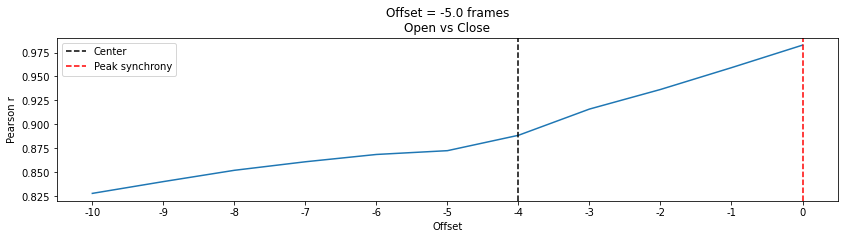

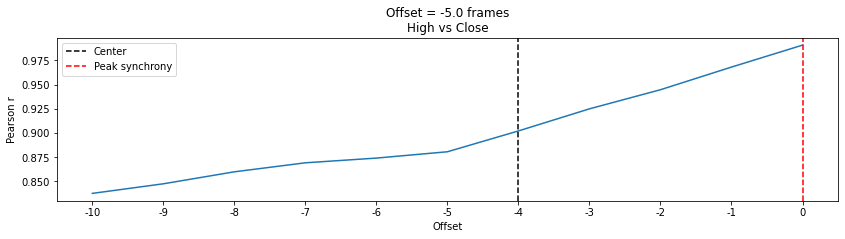

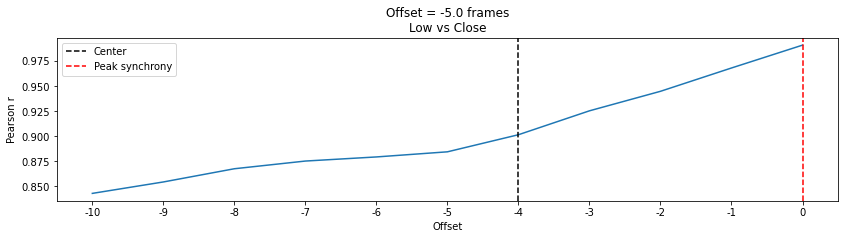

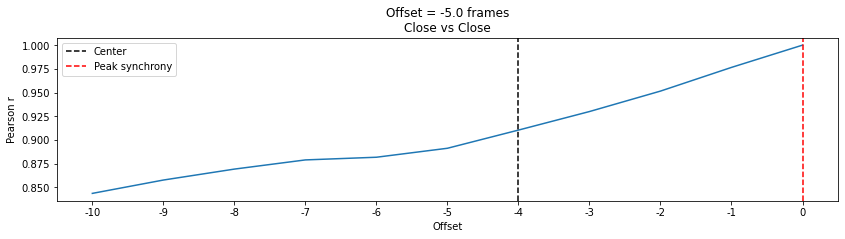

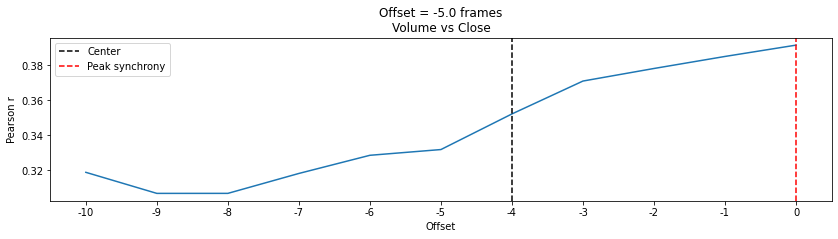

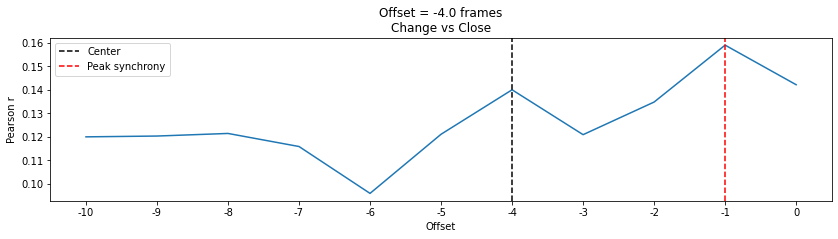

In [48]:
d2 = df_test["Close"]
for col in df_test.columns:
  d1 = df_test[col]
  xticks = list(range(-10,1))
  rs = [crosscorr(d1,d2, lag) for lag in xticks]
  offset = np.floor(len(rs)/2)-np.argmax(rs)
  f,ax=plt.subplots(figsize=(14,3))
  ax.plot(rs)
  ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
  ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
  ax.set(title=f'Offset = {offset} frames\n{col} vs Close', xlabel='Offset',ylabel='Pearson r')
  ax.set_xticks(range(len(xticks)))
  ax.set_xticklabels(xticks);
  plt.legend()

### WTLCC(Windowed Time-Lag Cross Correlation)

pandas rolling에도 correlation 기능을 제공한다.

- 참고 : https://www.statology.org/rolling-correlation-pandas/
- 문서 : https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.corr.html

In [ ]:
# Rolling window time lagged cross correlation
seconds = 5
fps = 30
window_size = 300 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['S1_Joy'].iloc[t_start:t_end]
    d2 = df['S2_Joy'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

In [36]:
# df_test = stock.copy()
print(f"window size : {step_size} | predict forward : {unit_size}")
df_temp = pd.DataFrame(np.nan, columns=df_test.columns, index=df_test.index[step_size-1:-unit_size])
for col in df_test.columns:
  temp = df_test[col].rolling(step_size).corr(df_test["Close"].shift(-unit_size)) # 과거 30일치로 다음주 5일 후를 살펴보자
  df_temp[col] = temp.dropna()

# lags = [15, 20, 25, 30, 35, 40]

# df_corr = pd.DataFrame.from_dict(
#     {x: 
#      [df_test[col].rolling(step).corr(df_test["Close"].shift(-unit_size)).dropna().values for step in lags]
#      for x in df_test.columns
#     }
# )

window size : 30 | predict forward : 5


In [37]:
df_temp

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-02-16,-0.042377,0.102793,-0.024698,0.129732,0.400621,0.078170
2021-02-17,0.097137,0.204061,0.121859,0.235823,0.424682,0.040947
2021-02-18,0.218311,0.290479,0.219223,0.287508,0.435059,0.002455
2021-02-19,0.327529,0.398683,0.341229,0.422137,0.424085,0.061145
2021-02-22,0.457686,0.518805,0.441526,0.548030,0.459803,0.038336
...,...,...,...,...,...,...
2021-11-08,0.491963,0.530025,0.568567,0.576239,-0.140577,0.130155
2021-11-09,0.293714,0.347967,0.385518,0.401028,-0.123755,0.141046
2021-11-10,0.096480,0.155574,0.188256,0.193318,-0.091580,0.096297


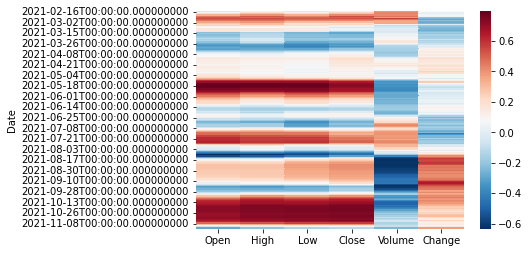

In [25]:
# fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_temp, cmap='RdBu_r')
# ax.set(title=f'Windowed',xlim=[0,301], xlabel='Offset',ylabel='Epochs')
# ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
# ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

-> 특정 시간대의 과거 30일치 window의 데이터 vs 다음주 5일 후의 종가의 상관 관계를 나타 낸 것.

-> 


### 위에서 선택한 features로 학습해보기

In [ ]:
## Get X data
# X = stock[["Change","Close","Volume"]]
# X = pd.concat([X, df_trend], axis=1)
X = df_test[["Close","OC","HL","Volume","Change","삼성전자: (대한민국)"]]
X.head()

,Close,OC,HL,Volume,Change,삼성전자: (대한민국)
Date,,,,,,
2021-01-04,83000,2000,4200,38655276,0.024691,78
2021-01-05,83900,2300,2300,35335669,0.010843,82
2021-01-06,82200,1100,2400,42089013,-0.020262,85
2021-01-07,82900,100,1500,32644642,0.008516,89
2021-01-08,88800,5500,7000,59013307,0.071170,92


In [ ]:
# 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
TARGET_COL_IDX = list(X.columns).index("Close")

In [ ]:
# minmax scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X.astype('float32'))
df = pd.DataFrame(scaled, columns=X.columns, index=X.index)

In [ ]:
scaled[:3]

array([[0.6396396 , 0.36363634, 0.5507246 , 0.36992046, 0.56207967,
        0.65573764],
       [0.6801803 , 0.4181818 , 0.2753623 , 0.3294252 , 0.43160465,
        0.72131145],
       [0.6036036 , 0.19999999, 0.28985506, 0.41180792, 0.13852926,
        0.7704917 ]], dtype=float32)

In [ ]:
# reshaping for LSTM input
X_reshaped, y_reshaped = [], []
for i in range(len(scaled) - step_size - unit_size + 1):
  cur_X = scaled[i:i+step_size,:]
  X_reshaped.append(cur_X)
  cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
  y_reshaped.append(cur_y)

X_reshaped = np.array(X_reshaped)
y_reshaped = np.array(y_reshaped)

print(f"X reshaped : {X_reshaped.shape}")
print(f"Y reshaped : {y_reshaped.shape}")

X reshaped : (170, 30, 6)
Y reshaped : (170, 5)


In [ ]:
# train test split
X_train, y_train = X_reshaped[:-4], y_reshaped[:-4]
X_test, y_test = X_reshaped[-4:], y_reshaped[-4:]

In [ ]:
# build model
model = Sequential()
model.add(LSTM(units=unit_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(unit_size))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5)                 240       
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 270
Trainable params: 270
Non-trainable params: 0
_________________________________________________________________


Epoch 1/80
10/10 - 4s - loss: 0.5219 - val_loss: 0.1391 - 4s/epoch - 369ms/step
Epoch 2/80
10/10 - 0s - loss: 0.4772 - val_loss: 0.1126 - 90ms/epoch - 9ms/step
Epoch 3/80
10/10 - 0s - loss: 0.4377 - val_loss: 0.1007 - 88ms/epoch - 9ms/step
Epoch 4/80
10/10 - 0s - loss: 0.3995 - val_loss: 0.1070 - 87ms/epoch - 9ms/step
Epoch 5/80
10/10 - 0s - loss: 0.3596 - val_loss: 0.1219 - 90ms/epoch - 9ms/step
Epoch 6/80
10/10 - 0s - loss: 0.3149 - val_loss: 0.1373 - 92ms/epoch - 9ms/step
Epoch 7/80
10/10 - 0s - loss: 0.2696 - val_loss: 0.1512 - 84ms/epoch - 8ms/step
Epoch 8/80
10/10 - 0s - loss: 0.2342 - val_loss: 0.1668 - 94ms/epoch - 9ms/step
Epoch 9/80
10/10 - 0s - loss: 0.2078 - val_loss: 0.1670 - 93ms/epoch - 9ms/step
Epoch 10/80
10/10 - 0s - loss: 0.1849 - val_loss: 0.1675 - 91ms/epoch - 9ms/step
Epoch 11/80
10/10 - 0s - loss: 0.1649 - val_loss: 0.1745 - 94ms/epoch - 9ms/step
Epoch 12/80
10/10 - 0s - loss: 0.1483 - val_loss: 0.1832 - 89ms/epoch - 9ms/step
Epoch 13/80
10/10 - 0s - loss: 0.1343

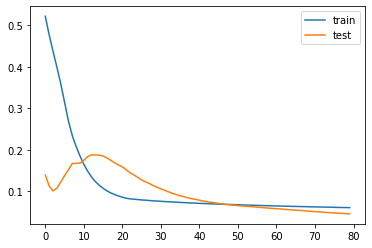

In [ ]:
# fitting
history = model.fit(X_train, y_train, epochs=80, batch_size=17, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# predict
y_hat = model.predict(X_test)

In [ ]:
y_hat

array([[0.086419  , 0.05132625, 0.2132679 , 0.04954344, 0.08524443],
       [0.08736947, 0.0518286 , 0.20809534, 0.04782487, 0.08149996],
       [0.09062846, 0.05510693, 0.20474443, 0.04983891, 0.08180724],
       [0.09255988, 0.05273392, 0.20209473, 0.04870969, 0.07508951]],
      dtype=float32)

In [ ]:
y_test

array([[0.06756759, 0.06306314, 0.07207203, 0.06306314, 0.1036036 ],
       [0.06306314, 0.07207203, 0.06306314, 0.1036036 , 0.05855846],
       [0.07207203, 0.06306314, 0.1036036 , 0.05855846, 0.08558559],
       [0.06306314, 0.1036036 , 0.05855846, 0.08558559, 0.04504514]],
      dtype=float32)

In [ ]:
y_hat.shape[0]

4

In [ ]:
padding = np.zeros((y_hat.shape[1], X_test.shape[2]))
padding

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
padding

array([[0.086419  , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.05132625, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.21326789, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.04954344, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.08524443, 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [ ]:
# reverse the reshape for inverse scaling

# yhat_total, ytest_total = [], []
for i in range(y_hat.shape[0]):
  padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

  padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
  inv_yhat = scaler.inverse_transform(padding)
  inv_yhat = inv_yhat[:, TARGET_COL_IDX]
  # yhat_total.append(inv_yhat)

  padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
  inv_ytest = scaler.inverse_transform(padding)
  inv_ytest = inv_ytest[:, TARGET_COL_IDX]
  # ytest_total.append(inv_ytest)
  print(
      f"NMAE *100 for ({i+1}/{y_hat.shape[0]}) : {nmae(inv_ytest, inv_yhat)[1]}"
      f"\n > y_true : {inv_ytest}"
      f"\n > y_hat  : {inv_yhat}"
  )
# yhat_total = np.array(yhat_total).reshape(1,-1)
# ytest_total = np.array(ytest_total).reshape(1,-1)

NMAE *100 for (1/4) : 1.283736355699081
 > y_true : [70300.00006203 70200.00144728 70399.99867678 70200.00144728
 71099.99956582]
 > y_hat  : [70718.50144986 69939.44244755 73534.54677025 69899.86401815
 70692.42601581]
NMAE *100 for (2/4) : 1.692133031631448
 > y_true : [70200.00144728 70399.99867678 70200.00144728 71099.99956582
 70099.99753963]
 > y_hat  : [70739.60189593 69950.59457168 73419.71614797 69861.71185784
 70609.29882616]
NMAE *100 for (3/4) : 0.882655448082232
 > y_true : [70399.99867678 70200.00144728 71099.99956582 70099.99753963
 70699.99981392]
 > y_hat  : [70811.95143358 70023.37357792 73345.32586953 69906.42348307
 70616.12037195]
NMAE *100 for (4/4) : 1.8346887082166106
 > y_true : [70200.00144728 71099.99956582 70099.99753963 70699.99981392
 69800.00169538]
 > y_hat  : [70854.82898892 69970.69275897 73286.50264903 69881.35485638
 70466.9868453 ]


In [ ]:
X.columns

Index(['Close', 'OC', 'HL', 'Volume', 'Change', '삼성전자: (대한민국)'], dtype='object')

### 전체 데이터셋 적용 : 제출용

우선 검색어는 빼고.

In [ ]:
start_date = '20210104'
# end_date = '20211029'
# start_date = '20211101'
end_date = '20211126'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'WEEKDAY of "end_date" : {pd.to_datetime(end_date).weekday()}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.tail())

WEEKDAY of "start_date" : 0
WEEKDAY of "end_date" : 4
NUM of WEEKS to "end_date" : 47
HOW MANY "Business_days" : (235, 1)


,Date
230,2021-11-22
231,2021-11-23
232,2021-11-24
233,2021-11-25
234,2021-11-26


In [ ]:
Business_days = Business_days.set_index("Date", drop=True)

In [ ]:
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index().set_index("Date", drop=True).sort_index()
    null_cnt = data.isnull().sum().sum()
    if null_cnt > 0:
      print(f'{stock_list[stock_list["종목코드"]==code]["종목명"]} null count : {null_cnt}')
    data.columns = [str(code) + "|" +  col for col in data.columns]
    Business_days = pd.merge(Business_days, data, how = 'outer', left_index=True, right_index=True)

100%|██████████| 370/370 [09:31<00:00,  1.55s/it]


In [ ]:
Business_days

,005930|Open,005930|High,005930|Low,005930|Close,005930|Volume,005930|Change,000660|Open,000660|High,000660|Low,000660|Close,000660|Volume,000660|Change,035420|Open,035420|High,035420|Low,035420|Close,035420|Volume,035420|Change,035720|Open,035720|High,035720|Low,035720|Close,035720|Volume,035720|Change,207940|Open,207940|High,207940|Low,207940|Close,207940|Volume,207940|Change,005935|Open,005935|High,005935|Low,005935|Close,005935|Volume,005935|Change,051910|Open,051910|High,051910|Low,051910|Close,...,035890|Low,035890|Close,035890|Volume,035890|Change,032620|Open,032620|High,032620|Low,032620|Close,032620|Volume,032620|Change,220630|Open,220630|High,220630|Low,220630|Close,220630|Volume,220630|Change,064260|Open,064260|High,064260|Low,064260|Close,064260|Volume,064260|Change,287410|Open,287410|High,287410|Low,287410|Close,287410|Volume,287410|Change,110790|Open,110790|High,110790|Low,110790|Close,110790|Volume,110790|Change,099320|Open,099320|High,099320|Low,099320|Close,099320|Volume,099320|Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,38655276.0,0.024691,124500.0,128000.0,120500.0,126000.0,7995016.0,0.063291,291500.0,294000.0,285500.0,293000.0,947178.0,0.001709,78680.0,79583.0,77375.0,79483.0,853740.0,0.016680,819000.0,838000.0,804000.0,829000.0,182864.0,0.003632,73700.0,75300.0,73600.0,74400.0,5455139.0,0.010870,849000.0,900000.0,835000.0,889000.0,...,1540.0,1610.0,5228125.0,0.052288,9630.0,9770.0,9560.0,9640.0,427853.0,0.004167,3780.0,3785.0,3670.0,3705.0,793611.0,-0.019841,4850.0,4870.0,4795.0,4835.0,832181.0,0.001035,4500.0,4520.0,4180.0,4200.0,1000825.0,-0.043280,25950.0,25950.0,23400.0,25850.0,20624.0,-0.003854,32950.0,33000.0,31750.0,31950.0,177448.0,-0.001563
2021-01-05,81600.0,83900.0,81600.0,83900.0,35335669.0,0.010843,124500.0,132500.0,124000.0,130500.0,7180224.0,0.035714,291500.0,292500.0,286500.0,292500.0,912657.0,-0.001706,78880.0,79381.0,77676.0,78881.0,748559.0,-0.007574,825000.0,834000.0,818000.0,832000.0,119911.0,0.003619,73600.0,75000.0,73600.0,75000.0,3870698.0,0.008065,891000.0,893000.0,875000.0,893000.0,...,1585.0,1700.0,6825806.0,0.055901,9570.0,10200.0,9400.0,9640.0,680925.0,0.000000,3645.0,3925.0,3565.0,3890.0,2477280.0,0.049933,4830.0,4850.0,4770.0,4820.0,1150798.0,-0.003102,4380.0,4535.0,4215.0,4240.0,884138.0,0.009524,25050.0,25850.0,24550.0,24750.0,20685.0,-0.042553,31750.0,32950.0,31600.0,32950.0,170757.0,0.031299
2021-01-06,83300.0,84500.0,82100.0,82200.0,42089013.0,-0.020262,132500.0,137000.0,130000.0,131000.0,8525749.0,0.003831,292500.0,300500.0,289500.0,290000.0,1375856.0,-0.008547,79282.0,82291.0,79181.0,79383.0,1435715.0,0.006364,828000.0,837000.0,816000.0,817000.0,145873.0,-0.018029,75000.0,75600.0,74200.0,74300.0,4103763.0,-0.009333,908000.0,912000.0,883000.0,890000.0,...,1670.0,1705.0,5380187.0,0.002941,9670.0,9870.0,9590.0,9780.0,484376.0,0.014523,3890.0,3890.0,3740.0,3755.0,830201.0,-0.034704,4835.0,4850.0,4775.0,4795.0,948804.0,-0.005187,4310.0,4310.0,4110.0,4295.0,466603.0,0.012972,24750.0,24950.0,24200.0,24750.0,5633.0,0.000000,33450.0,36000.0,33050.0,35350.0,487789.0,0.072838
2021-01-07,82800.0,84200.0,82700.0,82900.0,32644642.0,0.008516,132500.0,137500.0,131500.0,134500.0,5981299.0,0.026718,288500.0,292000.0,286500.0,289500.0,1155734.0,-0.001724,80687.0,80987.0,78880.0,80788.0,775191.0,0.017699,824000.0,824000.0,816000.0,819000.0,116480.0,0.002448,74400.0,74800.0,74300.0,74300.0,3858695.0,0.000000,910000.0,969000.0,896000.0,962000.0,...,1670.0,1725.0,2487175.0,0.011730,9860.0,9880.0,9680.0,9710.0,254276.0,-0.007157,3775.0,3830.0,3630.0,3650.0,729700.0,-0.027963,4820.0,4835.0,4790.0,4810.0,1127218.0,0.003128,4255.0,4555.0,4205.0,4480.0,610368.0,0.043073,25150.0,25150.0,23900.0,24750.0,43132.0,0.000000,35400.0,39950.0,35400.0,38200.0,704345.0,0.080622
2021-01-08,83300.0,90000.0,83000.0,88800.0,59013307.0,0.071170,136000.0,138000.0,132500.0,138000.0,8713010.0,0.026022,293500.0,312000.0,29000

In [ ]:
codes, cols = [], []
for item in [col.split("|") for col in Business_days.columns]:
  codes.append(item[0])
  cols.append(item[1])

In [ ]:
Business_days.columns = [codes, cols]

In [ ]:
Business_days = Business_days.ffill().bfill()

In [ ]:
# fdr fetch 시간이 오래걸리므로 저장해놓고 사용
Business_days.to_csv("./total_data_merged.csv")

** 저장해둔 csv로드

In [ ]:
data = pd.read_csv("total_data_merged.csv", index_col=0)

In [ ]:
cols = list(data.iloc[0,:].values)
data = data.iloc[2:]
data = data.astype(float)
codes = []
for i, col in enumerate(data.columns):
  codes.append(col.split(".")[0])
  if (i+1)%6 != 0:
    data[col] = data[col].astype(int)

data.columns = [codes, cols]
data.index = data.index.astype("datetime64[ns]")

In [ ]:
data

005930                       ... 099320                         
             Open   High    Low  Close  ...    Low  Close  Volume    Change
2021-01-04  81000  84400  80200  83000  ...  31750  31950  177448 -0.001563
2021-01-05  81600  83900  81600  83900  ...  31600  32950  170757  0.031299
2021-01-06  83300  84500  82100  82200  ...  33050  35350  487789  0.072838
2021-01-07  82800  84200  82700  82900  ...  35400  38200  704345  0.080622
2021-01-08  83300  90000  83000  88800  ...  36400  38300  354370  0.002618
...           ...    ...    ...    ...  ...    ...    ...     ...       ...
2021-11-15  71700  71900  70900  71400  ...  45850  46750   55491  0.010811
2021-11-16  71500  72000  71300  71300  ...  46700  48400  110230  0.035294
2021-11-17  71300  71600  70600  70700  ...  48100  49100   78265  0.014463
2021-11-18  70700  71000  70200  70200  ...  48600  48900   53934 -0.004073
2021-11-19  70400  71400  70100  71200  ...  48650  49600   43548  0.014315

[230 rows x 2220 columns]

In [ ]:
# check infinity or nans of original data
print(f"total infs : {np.isinf(data).values.sum()}")
print(f"total nans : {data.isna().sum().sum()}")

total infs : 0
total nans : 0


각 종목별 시도 필요. 370개..

In [ ]:
code_list = stock_list["종목코드"].values

In [ ]:
## X sequence size, Y sequence size 정의
step_size = 30 # 약 6주치
unit_size = 5 # 총 5일 예측할 것임

test_units = 1 # 테스트셋 묶음 갯수. unit_size * test_units = 총 테스트 데이터셋

In [ ]:
# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((test_units * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

# result.index = data.index[-(test_units * unit_size):] + pd.tseries.offsets.BDay(unit_size) # 날짜 index는 예측할 날짜로 맞춰준다 X. 학습할 y데이터를 맞출 것이므로, 여기서 맞출필요없음
result.index = data.index[-(test_units * unit_size):]

*** 이전에 작업한 result, model 호출 부분

In [ ]:
"""
이전에 작업한 result 호출
"""
result = pd.read_csv("temp_result.csv", index_col=0)
result = result.astype(float)
result.index = result.index.astype("datetime64[ns]")

res_nans = result.isna().sum()
nan_start = res_nans[res_nans > 0].index[0]
print(f"NaN starts from index {list(result.columns).index(nan_start)} (code : {nan_start})")

NaN starts from index 185 (code : 091990)


In [ ]:
#### !! 임시 : 저장된 일부모델 로드해서 결과 저장 중

# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((2 * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

# result.index = data.index[-(test_units * unit_size):] + pd.tseries.offsets.BDay(unit_size) # 날짜 index는 예측할 날짜로 맞춰준다 X. 학습할 y데이터를 맞출 것이므로, 여기서 맞출필요없음
result.index = list(data.index[-15:-10]) + list(data.index[-5:] + pd.tseries.offsets.BDay(10))

In [ ]:
result

,005930,000660,035420,035720,207940,005935,051910,006400,005380,068270,000270,005490,066570,028260,012330,096770,051900,017670,105560,055550,034730,036570,011200,015760,032830,018260,009150,090430,086790,251270,003670,352820,034020,010950,033780,003490,000810,010130,009540,326030,...,263720,143240,091700,067000,204270,032190,131370,321550,347860,003800,032300,122450,206640,015750,060720,043150,006730,089030,348150,319400,232140,083790,299030,049070,067310,036030,031390,121800,033310,086390,078020,102710,314130,035890,032620,220630,064260,287410,110790,099320
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-01,70782.360244,107654.571176,410241.906315,130916.728452,871959.828317,64439.449978,825198.661149,744611.571252,209263.368398,204949.695162,84746.169150,310288.589239,121711.811796,118511.302680,264802.837208,249517.786607,1.276143e+06,311611.945868,57224.715829,39567.932296,253889.453202,626633.193970,27179.034069,23074.238491,70992.209101,154600.950956,162513.521567,188207.769375,45223.468268,125825.245917,149562.166333,313458.197873,25401.463985,104023.896885,82424.420780,30813.443854,238541.916370,527886.303693,105552.702270,97975.405155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-02,73877.154490,107481.871247,406528.776228,130680.123923,885389.479339,65147.333714,834018.503785,739594.563365,210268.615484,224695.614651,86377.827829,311345.890284,125218.212008,118824.274786,273633.437201,249209.037885,1.215561e+06,310623.867571,57030.658197,39334.627995,256575.518370,617649.639130,28417.529178,22691.462097,70046.209002,154319.084384,158099.045455,186751.190025,45295.848280,124900.766045,149597.433805,332100.630587,24676.289663,102532.165742,81675.798631,30680.594296,236327.423096,526410.507143,103777.257268,94746.563934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-03,69247.849825,104460.473567,409285.843879,129681.377882,879024.239361,70690.067053,825714.366078,736812.516868,210266.266763,206490.357704,85826.964968,310631.565452,132072.496898,116533.314385,268974.149436,250224.415556,1.141847e+06,309882.538557,56429.645216,39172.483423,249863.766819,626911.979198,28326.339152,23011.157316,70085.338783,156888.227321,156027.300850,177880.893908,44900.539327,126463.746458,149446.461618,312086.127994,24275.813237,103222.223234,82339.405662,30766.704181,238511.470079,526983.843207,106599.160194,103037.339213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-04,69737.339910,104955.202192,409663.452655,131695.554620,883761.146724,66259.056759,835001.216084,736962.157607,213425.755262,205484.632611,84896.698135,315103.100777,130985.451899,123403.806150,260069.751658,249165.167451,1.193502e+06,309098.431110,57584.294021,38970.004037,252364.207417,629326.889992,29563.637261,23023.848100,68516.897321,154559.116136,159986.623108,184133.524477,45140.106785,127379.173040,148831.815928,316370.673856,24700.108439,100988.301682,82120.934612,30483.539283,229873.835802,526971.405983,105362.329620,100758.203268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-05,71626.334110,107059.875548,397122.893810,129643.417452,881411.131263,65674.749464,827660.923660,747967.806578,217922.821641,203273.496427,85859.759444,315245.407581,129356.630519,117767.695248,268667.085052,252309.109673,1.253147e+06,310083.046198,57400.556636,39883.568379,258030.935198,622148.511887,27338.694248,23002.702610,68236.949372,157098.103061,161838.768423,185693.136334,45294.402438,126032.403320,150340.668738,332682.810290,24377.884075,10

In [ ]:
## 데이터 끝단 확인(test X 확인)
data["005930"].iloc[-20:]

,Open,High,Low,Close,Volume,Change
2021-10-25,69900,70600,69500,70200,10029621,-0.002841
2021-10-26,70600,71500,70400,71100,10528252,0.012821
2021-10-27,71000,71000,70000,70100,10295316,-0.014065
2021-10-28,69500,72200,69500,70700,20644902,0.008559
2021-10-29,71200,71600,69700,69800,17016151,-0.012730
2021-11-01,70200,70600,69900,69900,11503729,0.001433
2021-11-02,70800,72200,70700,71500,16812570,0.022890
2021-11-03,71700,71700,70100,70400,12770428,-0.015385
2021-11-04,71200,71600,70500,70600,11818987,0.002841
2021-11-05,71600,71600,70200,70200,12667743,-0.005666


#### 참고) pandas SettingWithCopyWarning
pandas SettingWithCopyWarning 제거하는 코드. 다만 원칙 상 경고제거가 아닌, copy해서 쓰는게 맞다고 한다.

`pd.options.mode.chained_assignment = None  # default='warn'`

- [SettingWithCopyWarning 설명](https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning)
- [조치 및 해결법(stackoverflow)](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

In [ ]:
"""
total process 진행 : 위 개별코드를 for loop로 돌린 것

370개, 약 1년치 학습 데이터, 1주일치 테스트데이터에 대해 약 1시간 좀 넘게 걸림
"""
pd.options.mode.chained_assignment = None  # default='warn'

histories = []
nmae_results = {}

models = {}
failed_list = []

for idx, code in enumerate(tqdm(code_list[277:278])):
  # 1개 코드 가져오기
  X = data[code]

  # 여러가지 컬럼을 가공 및 믹스한 feature를 만들어내본다
  X["HL"] = X["High"] - X["Low"] # High - Low 차이
  X["OC"] = (X["Open"] - X["Close"]).abs() # Open, Close 차이
  X["band"] = X["OC"] / X["HL"] # High~Low 대비 Open~Close
  if np.isinf(X["band"]).values.sum() > 0: # 나눗셈은 분모가 0이면 inf값이 가능
    X["band"] = X["band"].replace([np.inf, -np.inf], np.nan).interpolate()
  if X["band"].isna().sum() > 0: # 나눗셈은 분모분자가 모두 0이면 NaN값이 가능
    X["band"] = X["band"].interpolate()

  # 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
  TARGET_COL_IDX = list(X.columns).index("Close")

  # minmax scaling
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(X)
  df = pd.DataFrame(scaled, columns=X.columns, index=X.index)

  # reshaping for LSTM input
  X_reshaped, y_reshaped = [], []
  for i in range(len(scaled) - step_size - unit_size + 1):
    cur_X = scaled[i:i+step_size,:]
    X_reshaped.append(cur_X)
    cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
    y_reshaped.append(cur_y)

  X_reshaped = np.array(X_reshaped)
  y_reshaped = np.array(y_reshaped)

  # train test split
  # X_train, y_train = X_reshaped[:-test_units], y_reshaped[:-test_units]
  # X_test, y_test = X_reshaped[-test_units:], y_reshaped[-test_units:]
  """
  *** 제출용 테스트셋 뽑아내기 ***(no y_test)
  11.01~11.05, 11.29~12.03 두 개 세트
  """
  X_train, y_train = X_reshaped[:-3], y_reshaped[:-3]
  X_test = np.array([scaled[-45:-15], scaled[-30:]])
  y_test = y_reshaped[-3] ##### 11.01 ~ 11.05 하나만 확인


  # build model
  model = Sequential()
  model.add(LSTM(units=unit_size, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(unit_size))
  model.compile(loss='mae', optimizer='adam')

  # fitting
  """
  *** 제출용 테스트셋 뽑아내기 *** y test 하나만 확인하기
  """
  # history = model.fit(X_train, y_train, epochs=70, batch_size=20, validation_data=(X_test, y_test), verbose=0, shuffle=False)
  history = model.fit(X_train, y_train, epochs=70, batch_size=20, validation_data=(np.array([list(X_test[0])]), np.array([list(y_test)])), verbose=0, shuffle=False)
  # if idx//30 == 0: # 30개정도씩 플롯 확인해보기
  histories.append((code, history))

  # predict
  y_hat = model.predict(X_test)
  yhat_total, ytest_total = [], []
  if np.isinf(y_hat)[0].sum() > 0 or np.isnan(y_hat)[0].sum() > 0:
      print(f"\n!!{code} failed. some invalid y_hat : {y_hat}")
      # result[code] = data[code]["Close"].iloc[-unit_size:] # 대충 지난주 원본 Close 데이터 입력
      # failed_list.append(code)
      eval = None
  else:
    # reverse the reshape for inverse scaling
    for i in range(y_hat.shape[0]):
      padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

      padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
      inv_yhat = scaler.inverse_transform(padding)
      inv_yhat = inv_yhat[:, TARGET_COL_IDX]
      yhat_total.append(inv_yhat)

      # padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
      # inv_ytest = scaler.inverse_transform(padding)
      # inv_ytest = inv_ytest[:, TARGET_COL_IDX]
      # ytest_total.append(inv_ytest)

      # eval = nmae(inv_ytest, inv_yhat)[1]
      # print(
      #     f"\n({code}) NMAE *100 : {eval}"
      # )
      # nmae_results[code] = eval
    """
    *** 제출용 테스트셋 뽑아내기 *** y test 하나만 확인하기
    """
    padding[:, TARGET_COL_IDX] = y_test
    inv_ytest = scaler.inverse_transform(padding)
    inv_ytest = inv_ytest[:, TARGET_COL_IDX]

    eval = nmae(inv_ytest, yhat_total[0])[1]
    print(
        f"\n({code}) NMAE *100 : {eval}"
    )
    nmae_results[code] = eval
  models[code] = {"model":model, "nmae":eval, "scaler":scaler}
  # result[code] = yhat_total[0] ##### 테스트셋 1개 이상일 시 변경 필요
  """
  *** 제출용 테스트셋 뽑아내기 ***(no y_test)
  """
  result[code] = np.array(yhat_total).reshape(-1,1) ##### 테스트셋 1개 이상일 시 변경 필요


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/70
10/10 - 3s - loss: 0.5743 - val_loss: 0.3309 - 3s/epoch - 281ms/step
Epoch 2/70
10/10 - 0s - loss: 0.4774 - val_loss: 0.2324 - 151ms/epoch - 15ms/step
Epoch 3/70
10/10 - 0s - loss: 0.3771 - val_loss: 0.1377 - 172ms/epoch - 17ms/step
Epoch 4/70
10/10 - 0s - loss: 0.2916 - val_loss: 0.0817 - 172ms/epoch - 17ms/step
Epoch 5/70
10/10 - 0s - loss: 0.2335 - val_loss: 0.1183 - 151ms/epoch - 15ms/step
Epoch 6/70
10/10 - 0s - loss: 0.2065 - val_loss: 0.1635 - 151ms/epoch - 15ms/step
Epoch 7/70
10/10 - 0s - loss: 0.1877 - val_loss: 0.1832 - 174ms/epoch - 17ms/step
Epoch 8/70
10/10 - 0s - loss: 0.1693 - val_loss: 0.1883 - 162ms/epoch - 16ms/step
Epoch 9/70
10/10 - 0s - loss: 0.1558 - val_loss: 0.1927 - 166ms/epoch - 17ms/step
Epoch 10/70
10/10 - 0s - loss: 0.1455 - val_loss: 0.2002 - 168ms/epoch - 17ms/step
Epoch 11/70
10/10 - 0s - loss: 0.1359 - val_loss: 0.2077 - 169ms/epoch - 17ms/step
Epoch 12/70
10/10 - 0s - loss: 0.1267 - val_loss: 0.2134 - 168ms/epoch - 17ms/step
Epoch 13/70
10/

100%|██████████| 1/1 [00:16<00:00, 16.77s/it]


(084110) NMAE *100 : 14.306932141536405


In [ ]:
#### !! 임시 : 저장된 일부모델 로드해서 결과 저장 중

# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((2 * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

# result.index = data.index[-(test_units * unit_size):] + pd.tseries.offsets.BDay(unit_size) # 날짜 index는 예측할 날짜로 맞춰준다 X. 학습할 y데이터를 맞출 것이므로, 여기서 맞출필요없음
result.index = list(data.index[-15:-10]) + list(data.index[-5:] + pd.tseries.offsets.BDay(10))

In [ ]:
list(result.columns).index("084110")

277

In [ ]:
result

,005930,000660,035420,035720,207940,005935,051910,006400,005380,068270,000270,005490,066570,028260,012330,096770,051900,017670,105560,055550,034730,036570,011200,015760,032830,018260,009150,090430,086790,251270,003670,352820,034020,010950,033780,003490,000810,010130,009540,326030,...,263720,143240,091700,067000,204270,032190,131370,321550,347860,003800,032300,122450,206640,015750,060720,043150,006730,089030,348150,319400,232140,083790,299030,049070,067310,036030,031390,121800,033310,086390,078020,102710,314130,035890,032620,220630,064260,287410,110790,099320
2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
이전 학습모델로 예측하기 : 임시코드
"""
pd.options.mode.chained_assignment = None  # default='warn'
for idx, code in enumerate(tqdm(code_list[185:])):
  model = load_model(f'saved_models/{str(code)}.keras')
  # scaler = joblib.load(f'saved_models/{str(code)}_scaler.pkl') # 나중엔 scaler도 저장 및 로드하자
  # 1개 코드 가져오기
  X = data[code]

  # 여러가지 컬럼을 가공 및 믹스한 feature를 만들어내본다
  X["HL"] = X["High"] - X["Low"] # High - Low 차이
  X["OC"] = (X["Open"] - X["Close"]).abs() # Open, Close 차이
  X["band"] = X["OC"] / X["HL"] # High~Low 대비 Open~Close
  if np.isinf(X["band"]).values.sum() > 0:
    X["band"] = X["band"].replace([np.inf, -np.inf], np.nan).interpolate()

  # 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
  TARGET_COL_IDX = list(X.columns).index("Close")

  # minmax scaling
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(X) ######
  joblib.dump(scaler, f"saved_models/{code}_scaler.pkl") #####

  # reshaping for LSTM input
  X_reshaped, y_reshaped = [], []
  for i in range(len(scaled) - step_size - unit_size + 1):
    cur_X = scaled[i:i+step_size,:]
    X_reshaped.append(cur_X)
    cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
    y_reshaped.append(cur_y)

  X_reshaped = np.array(X_reshaped)
  y_reshaped = np.array(y_reshaped)

  # train test split
  # X_train, y_train = X_reshaped[:-test_units], y_reshaped[:-test_units]####
  X_test = np.array(list(X_reshaped[-4:-3]) + list(X_reshaped[-1:]))####

  # predict
  y_hat = model.predict(X_test)
  if np.isinf(y_hat)[0].sum() > 0 or np.isnan(y_hat)[0].sum() > 0:
      print(f"\n!!{code} failed. some invalid y_hat : {y_hat}")
      # result[code] = data[code]["Close"].iloc[-unit_size:] # 대충 지난주 원본 Close 데이터 입력
      # failed_list.append(code)
      continue

  # reverse the reshape for inverse scaling
  yhat_total, ytest_total = [], []
  for i in range(y_hat.shape[0]):
    padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

    padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
    inv_yhat = scaler.inverse_transform(padding)
    inv_yhat = inv_yhat[:, TARGET_COL_IDX]
    yhat_total.append(inv_yhat)

    # padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
    # inv_ytest = scaler.inverse_transform(padding)
    # inv_ytest = inv_ytest[:, TARGET_COL_IDX]
    # ytest_total.append(inv_ytest)

    # eval = nmae(inv_ytest, inv_yhat)[1]
    # print(
    #     f"\n({code}) NMAE *100 : {eval}"
    # )
    # nmae_results[code] = eval

  # models[code] = {"model":model, "nmae":eval}
  result[code] = [*yhat_total[0], *yhat_total[1]] ##### 테스트셋 1개 이상일 시 변경 필요

 50%|████▉     | 92/185 [01:36<01:37,  1.05s/it]


OSError: ignored

#### 추론 결과 확인 및 모델 저장

In [ ]:
print(f"* failed list : {failed_list}")
res_nans = result.isna().sum()
print(res_nans[res_nans > 0])
nan_start = res_nans[res_nans > 0].index[0]
print(f"NaN starts from index {list(result.columns).index(nan_start)} (code : {nan_start})")

In [ ]:
# 모델 통째로 pickle 저장은 좋은 생각이 아닌 듯하다. 엄청 오래걸린다. 케라스 모델 저장을 이용하자..

# model file save by keras
for k, v in models.items():
  v["model"].save(f'saved_models/{str(k)}.keras')
  joblib.dump(v["scaler"], f"saved_models/{k}_scaler.pkl") 

In [ ]:
# submission 양식 맞추기
result.index.name = "Day"
result = result.reindex(sorted(result.columns), axis=1)
result.columns = [str(x).zfill(6) for x in result.columns]
result.to_csv("temp_result.csv")

In [ ]:
result.reset_index().to_csv("temp_result.csv",index=False)

추가 추론 : 모델 로드하여 예측데이터를 입력해 새로 예측.

학습 데이터에 포함 안 된 예측데이터를 넣도록.

In [ ]:
# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((test_units * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

# result.index = data.index[-(test_units * unit_size):] + pd.tseries.offsets.BDay(unit_size) # 날짜 index는 예측할 날짜로 맞춰준다 X. 학습할 y데이터를 맞출 것이므로, 여기서 맞출필요없음
result.index = data.index[-(test_units * unit_size):]

In [ ]:
# plot history
plot_max_row = len(histories) // 5 + (0 if len(histories)%5 == 0 else 1)
fig, ax = plt.subplots(plot_max_row,5,figsize=(18,plot_max_row*3))
for i, item in enumerate(histories):
  ax[i//5][i%5].plot(item[1].history['loss'], label='train', color="blue")
  ax[i//5][i%5].plot(item[1].history['val_loss'], label='test', color="orange")
  ax[i//5][i%5].legend()
  ax[i//5][i%5].set_title(str(item[0]))
plt.tight_layout()
plt.show()